# Relationship between object and lens orientation angles in Scheimpflug imaging

In [11]:
from __future__ import print_function, division
import os
import numpy as np
import sympy as sy

In [12]:
%matplotlib inline

In [13]:
# Helper functions
sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))
arcsind = lambda x : np.rad2deg(np.arcsin(x))
arccosd = lambda x : np.rad2deg(np.arccos(x))
arctand = lambda x : np.rad2deg(np.arctan(x))

# Helper function for saving figures
curDir = os.getcwd()
imgdir = os.path.join(curDir, 'images')
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    print("Created 'images' directory")


bSaveFigure = True
fig_format, fig_ext = 'png', '.png'
def saveFigure(figure, fig_name, DPI=120):
    if bSaveFigure:
        figname = os.path.join(imgdir, fig_name)
        print('figname:', figname)
        figure.savefig(figname, dpi=DPI, facecolor='white', edgecolor='white',
                       bbox_inches='tight', format=fig_format, pad_inches=0.03)

### Index

1. [Rotation of lens about a pivot away from the ENPP](#Rotation-of-lens-about-a-pivot-away-from-the-ENPP)
2. [Lens rotated about the x-axis at ENPP](#Lens-rotated-about-the-x-axis-at-ENPP)
3. [Iterative algorithm for finding lens tilt angle α](#Iterative-algorithm-for-finding-lens-tilt-angle-$\alpha$)

## Rotation of lens about a pivot away from the ENPP

If the object plane is tilted about one axis (let's say the x-axis) by and angle $\beta$ (such that, it makes angle $\beta$ w.r.t. the vertical, y-axis), then the lens must also be rotated in the same direction (i.e. about the x-axis). If the angle of rotation of the lens is $\alpha$, then in order for the tilted object to be in focus, $\alpha$ and $\beta$ must satisfy the following relationship:

$$
\tan \,\beta = -\frac{\sin \,\alpha \left[ m_p(z_o - d_e \cos \,\alpha) + f(1-m_p) \cos \,\alpha \right]}{(f - m_p d_e \sin^2 \alpha)(m_p \cos^2 \alpha + \sin^2 \alpha)+m_p(1-m_p)d_e \sin^2 \alpha \, \cos^2 \alpha}
$$

We will often refer to the R.H.S. of the above equation as $F(\alpha)$.

#### Lens rotated about a changing pivot point

In [14]:
# Functions for analysing the effects of lens rotation

def get_beta_shifting_pivot(x, de, zo, f, mp, alpha):
    """compute the object tilt angle (orientation of PoSF) for lens tilted about the x-axis
    about a point (de + x) distance from the ENPP. 
    
    @param: x: increment in distance of ENPP from {C} in fronto-parallel configuration
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: zo: directed distance of object plane from {C} 
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    """
    c = cosd(alpha)
    s = sind(alpha)
    numr = s*( mp*(zo + x - (de + x)*c) + f*(1 - mp)*c)
    deno = (f - mp*(de + x)*s**2)*(mp*c**2 + s**2) + (de + x)*mp*(1-mp)*(s**2)*(c**2)
    return -arctand(numr/deno)

def get_beta(de, zo, f, mp, alpha):
    """compute the object tilt angle (orientation of PoSF) for lens tilted about the x-axis
    about a point (de) distance from the ENPP. 
    
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: zo: directed distance of object plane from {C} 
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    """
    return get_beta_shifting_pivot(0.0, de, zo, f, mp, alpha)

def get_zoDash(zo, alpha, beta, f, mp, de, deDash):
    """compute image plane distance (along z-axis of {C})
    
    @param: zo: directed distance of object plane from {C} 
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    @param: beta: angle of rotation (in degrees) of the object plane about it's pivot about x-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: deDash: directed distance of EXPP from {C} in fronto-parallel configuration.
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = tand(beta)
    z = zo - de*(s*t + c)
    numr = mp*f*(mp*c**2 + s**2)*z
    deno = mp*c*z + f
    return deDash*c + numr/deno

def get_tanBeta(de, zo, f, mp, alpha):
    """same as the function `get_beta()`, except that it returns tan(beta) instead of beta
    """
    c = cosd(alpha)
    s = sind(alpha)
    numr = -s*(mp*(zo - de*c) + f*(1 - mp)*c)
    deno = (f - mp*de*s**2)*(mp*c**2 + s**2) + de*mp*(1-mp)*(s**2)*(c**2)
    return numr/deno

def beta_thin(zo, f, alpha):
    """compute beta using thin-lens approximation. If the lens is rotated about the ENPP
    and the pupil magnification equals one, then this relation is exact too.
    """
    return -arctand(zo*sind(alpha)/f)

In [15]:
# ex. optical system "paraxialDoubleLens24mmFiniteConj_mp2.zmx"
zo = -509.0
f = 24.0
mp = 2.0
de = -5.0        # along the optical axis
deDash = -25.0   # along the optical axis

#Image position (zoDash): 24.1707317
#Obj. distance from ENPP (|ze|): 504.0
#Image position from EXPP (|zeDash|): 49.1707316951

# First we ensure that the object-to-ENPP distance (ze) and EXPP-to-image distance (zeDash)
# remains fixed in frontoparallel configuration for different values of x.
alpha = 0
for x in range(3):
    zoNew = zo + x
    deNew = de + x
    deDashNew = deDash + x
    ze = zoNew - deNew*cosd(alpha)
    # since the function get_zoDash computes zoNew, and deNew we just pass zo and de (the initial values)
    beta = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alpha) 
    zoDash = get_zoDash(zo=zoNew, alpha=alpha, beta=beta, f=f, mp=mp, de=deNew, deDash=deDashNew)
    zeDash = zoDash - deDashNew*cosd(alpha)
    print(('zo = {:3.2f}, zoDash = {:3.2f}, d = {:3.2f}, ze = {:3.2f}, zeDash = {:3.2f}'
           .format(zoNew, zoDash, deDashNew - deNew, ze, zeDash)))

zo = -509.00, zoDash = 24.17, d = -20.00, ze = -504.00, zeDash = 49.17
zo = -508.00, zoDash = 25.17, d = -20.00, ze = -504.00, zeDash = 49.17
zo = -507.00, zoDash = 26.17, d = -20.00, ze = -504.00, zeDash = 49.17


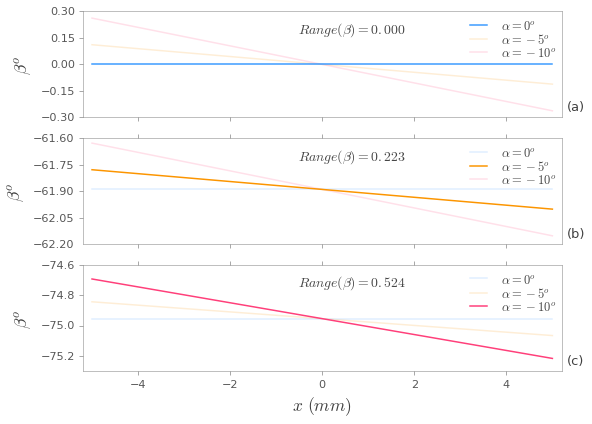

In [16]:
FIGURE_FOR_WORD = False

alphaArr = [0, -5, -10]

if FIGURE_FOR_WORD:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
    tsf = 1.25
    
(ax0, ax1, ax2) = axes.flatten()

x = np.linspace(-5, 5, 21)   # range of displacements

beta0 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[0])
beta1 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[1])
beta2 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[2])
beta0Mean = np.mean(beta0)
beta1Mean = np.mean(beta1)
beta2Mean = np.mean(beta2)

rangeBeta0 = '{:0.3f}'.format(np.max(beta0) - np.min(beta0))
rangeBeta1 = '{:0.3f}'.format(np.max(beta1) - np.min(beta1))
rangeBeta2 = '{:0.3f}'.format(np.max(beta2) - np.min(beta2))

# figure  (the figure and font size in the figure are optimized for saving for embedding into word)
#print(beta0Mean, beta1Mean, beta2Mean)
alphaLight = 0.16
lwLight = 1.5
lwEmph = 1.5

ax0.plot(x, beta0, color='#3A9AFF', lw=lwEmph, 
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=10)
ax0.plot(x, beta1 - beta1Mean,  color='#FC9500', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=8)
ax0.plot(x, beta2 - beta2Mean, color='#FF3F7A', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=8)
ax0.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta0), fontsize=11*tsf, transform=ax0.transAxes)
#
ax1.plot(x, beta0 + beta1Mean, color='#3A9AFF', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=8)
ax1.plot(x, beta1, color='#FC9500', lw=lwEmph,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=10)
ax1.plot(x, beta2 + (beta1Mean - beta2Mean), color='#FF3F7A', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=8)
ax1.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta1), fontsize=11*tsf, transform=ax1.transAxes)
#
ax2.plot(x, beta0 + beta2Mean, color='#3A9AFF', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=8)
ax2.plot(x, beta1 + (beta2Mean - beta1Mean), color='#FC9500', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=8)
ax2.plot(x, beta2, color='#FF3F7A', lw=lwEmph,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=10)
ax2.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta2), fontsize=11*tsf, transform=ax2.transAxes)

# plot decorations
# common to all axes
for l, ax in zip(['(a)', '(b)', '(c)'], [ax0, ax1, ax2]):
    ax.set_xlim(x[0]-0.2, x[-1] + 0.2)                # x limit
    #ax.grid(axis='y', alpha=0.4)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))    # number of ticks
    ax.yaxis.set_ticks_position('left')               # tick 
    ax.set_ylabel(r'$\beta^o$', fontsize=14*tsf)          # y-label
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)
    # legend
    ax.legend(loc=(0.79, 0.5), labelspacing=0.008, fontsize=10*tsf)
    # subplot id label  
    ax.text(1.01, 0.065, l, fontsize=13, color='#404040', transform=ax.transAxes)
    
ax0.xaxis.set_ticks_position('bottom')
ax2.set_xlabel(r'$x\,\,(mm)$', fontsize=14*tsf)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'object_tilt_angle_with_pivot_movement.png')

plt.show()

<font color='red'>**Question**</font> For given $\alpha$ do we always get unique $\beta$?

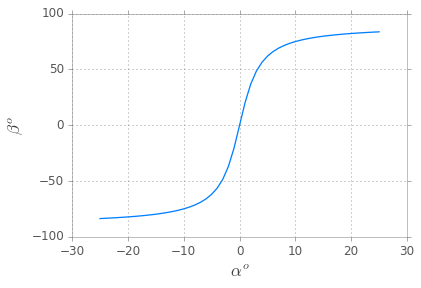

In [17]:
# plot of alpha vs. beta  
# this plot shows that given alpha, we can get a unique beta within +/-90°
alpha = np.linspace(-25., 25., 51)
beta = get_beta(de=-5.0, zo=-509.0, f=24.0, mp=2.0, alpha=alpha)

plt.plot(alpha, beta)
plt.xlabel(r'$\alpha^o$', fontsize=17)
plt.ylabel(r'$\beta^o$', fontsize=17)
plt.grid()
plt.show()

The above plot seems to suggest that we get unique $\beta$ for a given $\alpha$. Note that although the `tan` function is not monotonic over the whole domain of real numbers, it is monotonic in $[-\pi/2, \pi/2]$. 

But .... 

As we can see in the figures below, $F(\alpha)$ <font color='red'>**may not be monotonic**</font>. Therefore, we might end up getting multiple values of $\beta$ (and $\tan \,\beta$) for the same value of $\alpha$. So, there are some combinations of the optical system parameters that makes $F(\alpha)$ non-monotonic.

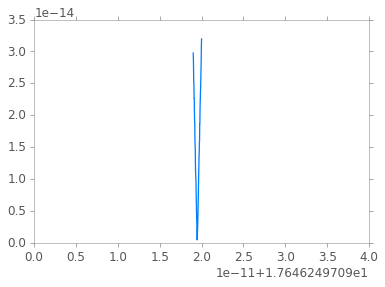

3.1330701123 3.1330701123 72.298177969


In [18]:
# emperically find alpha values for which we get same value of beta 
# Here, I manually found the second alpha by minimized the error visually!

zo=-509.0
f = 24.0
de=-5.0

mp=0.15; alpha=45
#mp=0.1; alpha=15

tBeta0 = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
#alphaArr = np.linspace(33.837970239821, 33.837970239825) # for mp=0.1; alpha=15
alphaArr = np.linspace(17.646249708999, 17.646249709)   # for mp=0.15; alpha=45
absErr = []
for each in alphaArr:
    tBeta1 = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=each)
    absErr.append(abs(tBeta1 - tBeta0))

absErr = np.array(absErr)

plt.plot(alphaArr, absErr)
plt.show()

print(get_tanBeta(de=de, zo=zo, f=f, mp=0.15, alpha=17.646249709), 
      get_tanBeta(de=de, zo=zo, f=f, mp=0.15, alpha=45.0), 
      get_beta(de=de, zo=zo, f=f, mp=0.15, alpha=45))

#print(get_tanBeta(de=de, zo=zo, f=f, mp=0.1, alpha=15.0), 
#      get_tanBeta(de=de, zo=zo, f=f, mp=0.1, alpha=33.837970239821), 
#      get_beta(de=de, zo=zo, f=f, mp=0.1, alpha=15))

# Emperically found
# for mp=0.15; alpha=17.646249709, 45; tanbeta = 3.1330701123; beta = 72.298177969
# for mp=0.1; alpha=15.0, 33.837970239821; tanbeta = 2.00014403634; beta = 63.4365992627

The following plots demonstrates that for some values of $m_p$ (or perhaps, for certain combination of lens parameters $m_p$, $f$, $d_e$ and object distance $z_o$), the plot of $F(\alpha)$ (and therefore $\beta$) is not monotonic for increasing values of $\alpha$. 

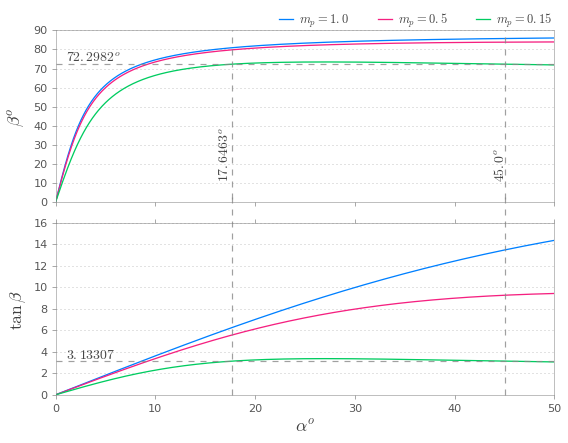

In [108]:
# plot of alpha vs. beta 

FIGURE_FOR_WORD = False

# this plot shows that given alpha, we MAY NOT get a unique beta within +/-90°
zo = -509.0
f = 24.0
de = -5.0


if FIGURE_FOR_WORD:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    tsf = 1.25

alpha = np.linspace(0., 50., 1000)

for i, mp in enumerate([1.0, 0.5, 0.15,]):
    beta = get_beta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
    tBeta = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, beta, label=legTxt)
    ax1.plot(alpha, tBeta, label=legTxt)
    
# plot the non-unique alpha, beta points for illustration
# These values were emperically found
# for mp=0.15; alpha=17.646249709, 45; tanbeta = 3.1330701123; beta = 72.298177969
ax0.axhline(72.298177969, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axhline(3.1330701123, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(17.646249709, ymin=0.02, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(45.0, ymin=0.02, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axvline(x=17.646249709, ymin=0, ymax=1.15, color='#888888', alpha=0.8, lw=1.2, 
            linestyle='dashed', clip_on=False)
ax1.axvline(x=45.0, ymin=0, ymax=1.15, color='#888888', alpha=0.8, lw=1.2, 
            linestyle='dashed', clip_on=False)
# for mp=0.1; alpha=15.0, 33.837970239821; tanbeta = 2.00014403634; beta = 63.4365992627
#ax0.axhline(63.4365992627)
#ax1.axhline(2.00014403634)

# figure decorations
for ax in [ax0, ax1]:
    ax.grid(axis='y', alpha=0.6)
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))    # number of ticks
    ax.yaxis.set_ticks_position('left')                # tick
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)

# Text to indicate angles
ax0.text(1, 74,  r'$72.2982^o$', fontsize=11*tsf)
ax1.text(1, 3.4, r'$3.13307$', fontsize=11*tsf)
ax0.text(16.3, 11,  r'$17.6463^o$', rotation='vertical', va='bottom', fontsize=11*tsf)
ax0.text(43.8, 11,  r'$45.0^o$', rotation='vertical', va='bottom', fontsize=11*tsf)

ax0.xaxis.set_ticks_position('bottom')
ax1.set_xlabel(r'$\alpha^o$', fontsize=14*tsf)
ax0.set_ylabel(r'$\beta^o$', fontsize=14*tsf)
ax1.set_ylabel(r'$\rm{tan}\, \beta$', fontsize=14*tsf)
# legend
#ax.legend(loc=(0.01, 0.8), labelspacing=0.008, fontsize=10*tsf)

ax0.legend(fontsize=10*tsf, ncol=3, loc='lower left', bbox_to_anchor=(0.465, 0.94, 0.5, 0.5), 
          bbox_transform=fig.transFigure, handletextpad=0.2, handlelength=1.7)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'alpha_vs_beta_with_mp_lens_tilt_away_from_enpp.png')

plt.show()

So, now we need to answer the following **two questions**:

(1) How can we detect the situation when multiple (probably just two) $\alpha$ for which we get the same $\beta$?

(2) Can we find an algebraic expression (a function of the relevant optical parameters) for the condition?

In order to answer (1), we can take the derivative of $F(\alpha)$ w.r.t. $\alpha$ and find out if the derivative, $F'(\alpha)$, is always positive (monotonically increasing) or always negative (monotonically decreasing) with an interval $[a, b]$. If $F'(\alpha)$ changes sign within the chosen interval $[a, b]$, then $F(\alpha)$ is not monotonic. In other words, if we can find real roots of $F'(\alpha)$, then $F(\alpha)$ is not monotonic. 

We will find the derivative using SymPy.

In [10]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a, mp, zo, f, de = sy.symbols('alpha, m_p, z_o, f, d_e', real=True)
numr = -sy.sin(a)*(mp*(zo - de*sy.cos(a)) + f*(1 - mp)*sy.cos(a))
deno = (f - mp*de*sy.sin(a)**2)*(mp*sy.cos(a)**2 + sy.sin(a)**2) + mp*(1-mp)*de*sy.sin(a)**2*sy.cos(a)**2
expr = numr/deno
expr

              -(f⋅(-m_p + 1)⋅cos(α) + m_p⋅(-dₑ⋅cos(α) + zₒ))⋅sin(α)           
──────────────────────────────────────────────────────────────────────────────
                     2       2      ⎛       2         2   ⎞ ⎛            2    
dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p⋅sin (α) 

    
────
   ⎞
+ f⎠

In [11]:
sy.diff(expr, a)

                                                                              
                     (dₑ⋅m_p⋅sin(α) - f⋅(-m_p + 1)⋅sin(α))⋅sin(α)             
- ────────────────────────────────────────────────────────────────────────────
                       2       2      ⎛       2         2   ⎞ ⎛            2  
  dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p⋅sin (α
                                                                              

                                                                              
                        (f⋅(-m_p + 1)⋅cos(α) + m_p⋅(-dₑ⋅cos(α) + zₒ))⋅cos(α)  
────── - ─────────────────────────────────────────────────────────────────────
     ⎞                        2       2      ⎛       2         2   ⎞ ⎛        
) + f⎠   dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p
                                                                              

                                                  

Well ... well ... well! That is getting a little too complicated. Let's abandon it for now, and examine the more relevant case of rotating the lens about the ENPP, which we expect to be simpler. If we find a useful strategy, then we can come back and apply the same strategy here.

## Lens rotated about the x-axis at ENPP

If the lens is rotated about the ENPP ($d_e = 0$), the expression for $\tan \,\beta$ (or equivalently the expression for $F(\alpha)$) reduces to:

$$
tan \,\beta = F(\alpha) =
- \frac{\sin\,\alpha \left( m_p z_o +  f \left(1 - m_p \right) \cos \,\alpha \right)}{f \left(m_p \cos^2\alpha + \sin^2\alpha \right)}
$$

The image plane distance is given by

$$
\acute{z}_{o} = d \cos\,\alpha + \frac{m_p z_o f (m_p \cos^2\alpha + \sin^2\alpha)}{m_p z_o \cos\,\alpha + f}
$$


In [110]:
def get_zoDash2(zo, f, mp, d, alpha):
    """formula for computing the image plane distance from the pivot 
    (origin of {C}) if lens is tilted about the ENPP. i.e. de=0, deDash=d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: d: distance from ENPP to EXPP
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    
    Note:
    Assuming zo is numerically negative,
        o zoDash is +ve if |zo*mp*c| > f; image is real and inverted
        o zoDash is  ∞  if |zo*mp*c| = f
        o zoDash is -ve if |zo*mp*c| < f
    """
    c = cosd(alpha)
    s = sind(alpha)
    return d*c + mp*f*zo*(mp*c**2 + s**2)/(zo*mp*c + f)

def get_beta2(zo, f, mp, alpha):
    """formula for computing the object plane tilt angle if lens is 
    tilted about the ENPP. That is de=0, deDash=d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return arctand(t)

def get_tanBeta2(zo, f, mp, alpha):
    """
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return t

As before, we will find the derivative of $F(\alpha)$ using SymPy.

In [13]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a, mp, zo, f, de = sy.symbols('alpha, m_p, z_o, f, d_e', real=True)
numr = -sy.sin(a)*(mp*zo + f*(1 - mp)*sy.cos(a))
deno = f*(mp*sy.cos(a)**2 + sy.sin(a)**2)
expr = numr/deno
expr

-(f⋅(-m_p + 1)⋅cos(α) + m_p⋅zₒ)⋅sin(α) 
───────────────────────────────────────
         ⎛       2         2   ⎞       
       f⋅⎝m_p⋅cos (α) + sin (α)⎠       

In [14]:
firstDeri = sy.diff(expr, a)
firstDeri

                2                                                             
  (-m_p + 1)⋅sin (α)    (f⋅(-m_p + 1)⋅cos(α) + m_p⋅zₒ)⋅cos(α)   (f⋅(-m_p + 1)⋅
───────────────────── - ───────────────────────────────────── - ──────────────
       2         2              ⎛       2         2   ⎞                       
m_p⋅cos (α) + sin (α)         f⋅⎝m_p⋅cos (α) + sin (α)⎠                       
                                                                              

                                                               
cos(α) + m_p⋅zₒ)⋅(2⋅m_p⋅sin(α)⋅cos(α) - 2⋅sin(α)⋅cos(α))⋅sin(α)
───────────────────────────────────────────────────────────────
                                     2                         
              ⎛       2         2   ⎞                          
            f⋅⎝m_p⋅cos (α) + sin (α)⎠                          

In [15]:
firstDeri = sy.simplify(firstDeri)
firstDeri

     2    2                   2             2       3           2             
f⋅m_p ⋅cos (α) - f⋅m_p - f⋅cos (α) + f + m_p ⋅zₒ⋅cos (α) - 2⋅m_p ⋅zₒ⋅cos(α) - 
──────────────────────────────────────────────────────────────────────────────
                                                                  2           
                                           ⎛       2         2   ⎞            
                                         f⋅⎝m_p⋅cos (α) + sin (α)⎠            

          3                   
m_p⋅zₒ⋅cos (α) + m_p⋅zₒ⋅cos(α)
──────────────────────────────
                              
                              
                              

In [33]:
# turn off sympy's pretty printing 
sy.init_printing(pretty_print=False, use_latex=False)

The first derivative $F'(\alpha)$ is the following cubic (in $\cos \,\alpha$) equation:

$$
F'(\alpha) = \frac{-1}{f \left(m_p \cos^2\alpha + \sin^2\alpha \right)^2 }\, \left[ m_p (1 - m_p) z_o \cos^3\alpha + f(1 - m_p^2) \cos^2\alpha - m_p (1 - 2 m_p) z_o \cos \,\alpha - f(1-m_p) \right]
$$

We can readily examine the case when $m_p=1$:

$$
F'(\alpha) = -\frac{z_o}{f} \cos \,\alpha
$$

In the interval $[-\pi/2, \pi/2]$, $F'(\alpha)$ is always positive since $z_o$ (directed object distance from the camera frame origin) is numerically negative. Therefore, $F(\alpha)$ is a monotonically increasing function if $m_p=1$. Also, since $F(\alpha)$ is a monotonically increasing function if $m_p=1$, we expect $\beta$ to increase with increasing $\alpha$.  

In [111]:
def first_derivative_Falpha(zo, f, mp, alpha):
    """evaluate the first derivative of the F(alpha). 
    
    It is assumed that the lens is rotated about the ENPP. Therefore, 
    the first derivative is a cubic equation in cos(alpha)
    """
    a = -mp*(1 - mp)*zo
    b = -f*(1 - mp**2)
    c = mp*(1 - 2*mp)*zo
    d = f*(1 - mp)
    numr = a*cosd(alpha)**3 + b*cosd(alpha)**2 + c*cosd(alpha) + d
    deno = f*(mp*cosd(alpha)**2 + sind(alpha)**2)**2
    firstDeri = numr/deno
    return firstDeri

def roots_first_derivative_Falpha(zo, f, mp):
    """returns the roots and discriminant of F'(alpha)
    
    It is assumed that the lens is rotated about the ENPP. Therefore, 
    the first derivative is a cubic equation in cos(alpha)
    """
    a = -mp*(1 - mp)*zo
    b = -f*(1 - mp**2)
    c = mp*(1 - 2*mp)*zo
    d = f*(1 - mp)
    roots = np.roots([a, b, c, d])
    discriminant = (b**2)*(c**2) - 4*a*(c**3) - 4*(b**3)*d - 27*(a**2)*(d**2) + 18*a*b*c*d
    return roots, discriminant

Like before, we will first emperically find cases of multiple $\alpha$ that result in same $\beta$.

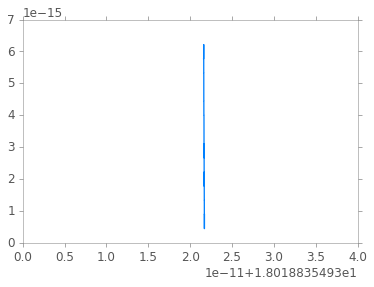

3.17301469156 3.17301469156 72.5073533271


In [17]:
# emperically find alpha s for which we get multiple values of beta 

zo=-509.0
f = 24.0

mp=0.15; alpha=45

tBeta0 = get_tanBeta2(zo=zo, f=f, mp=mp, alpha=45)
alphaArr = np.linspace(18.0188354928516, 18.0188354928517)
absErr = []
for each in alphaArr:
    tBeta1 = get_tanBeta2(zo=zo, f=f, mp=mp, alpha=each)
    absErr.append(abs(tBeta1 - tBeta0))

absErr = np.array(absErr)

plt.plot(alphaArr, absErr)
plt.show()

print(get_tanBeta2(zo=zo, f=f, mp=0.15, alpha=18.0188354928516), 
      get_tanBeta2(zo=zo, f=f, mp=0.15, alpha=45.0), 
      get_beta2(zo=zo, f=f, mp=0.15, alpha=45))

# Emperically found
# for mp=0.15; alpha=18.0188354928516, 45; tanbeta = 3.17301469156; beta = 72.5073533271

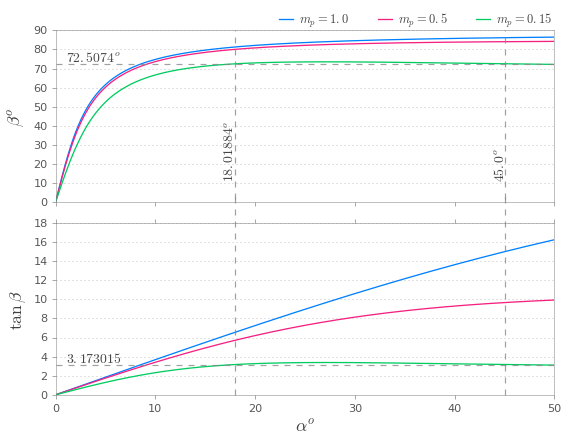

In [121]:
# plot of alpha vs. beta 

FIGURE_FOR_WORD = False

if FIGURE_FOR_WORD:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    tsf = 1.25
#fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))


# this plot shows that given alpha, we MAY NOT get a unique beta within +/-90°
zo=-509.0
f = 24.0

alpha = np.linspace(0., 50., 1000)
for i, mp in enumerate([1.0, 0.5, 0.15, ]):
    beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alpha)
    tBeta = get_tanBeta2(zo=zo, f=f, mp=mp, alpha=alpha)
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, beta, label=legTxt)
    ax1.plot(alpha, tBeta, label=legTxt)
    #ax2.plot(alpha, first_derivative(zo, f, mp, alpha))
    
# plot the non-unique alpha, beta points for illustration
# These values were emperically found
# for mp=0.15; alpha=18.0188354928516, 45; tanbeta = 3.17301469156; beta = 72.5073533271
ax0.axhline(72.5073533271, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axhline(3.17301469156, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(18.0188354928516, ymin=0.02, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(45.0, ymin=0.02, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axvline(x=18.0188354928516, ymin=0, ymax=1.15, color='#888888', alpha=0.8, lw=1.2, 
            linestyle='dashed', clip_on=False)
ax1.axvline(x=45.0, ymin=0, ymax=1.15, color='#888888', alpha=0.8, lw=1.2, 
            linestyle='dashed', clip_on=False)
#ax2.axhline(color='#555555', alpha=0.8, lw=1.2, linestyle='dashed')

# plot decorations
#ax2.set_ylim(-1.5, 21)
for ax in [ax0, ax1, ax2]:
    ax.grid(axis='y', alpha=0.6)
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))    # number of ticks
    ax.yaxis.set_ticks_position('left')               # tick
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)

# Text to indicate angles
ax0.text(1, 74,  r'$72.5074^o$', fontsize=11*tsf)
ax1.text(1, 3.4, r'$3.173015$', fontsize=11*tsf)
ax0.text(16.8, 11,  r'$18.01884^o$', rotation='vertical', va='bottom', fontsize=11*tsf)
ax0.text(43.8, 11,  r'$45.0^o$', rotation='vertical', va='bottom', fontsize=11*tsf)

#ax.legend(loc=(0.01, 0.8), labelspacing=0.008, fontsize=14)
ax0.xaxis.set_ticks_position('bottom')
ax1.set_xlabel(r'$\alpha^o$', fontsize=14*tsf)
ax0.set_ylabel(r'$\beta^o$', fontsize=14*tsf)
ax1.set_ylabel(r'$\rm{tan}\, \beta$', fontsize=14*tsf)
#ax2.set_ylabel(r'$d/dx \, [F(\alpha)]$')

ax0.legend(fontsize=10*tsf, ncol=3, loc='lower left', bbox_to_anchor=(0.465, 0.94, 0.5, 0.5), 
           bbox_transform=fig.transFigure, handletextpad=0.2, handlelength=1.7)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'alpha_vs_beta_with_mp_lens_tilt_away_about_enpp.png')

plt.show()

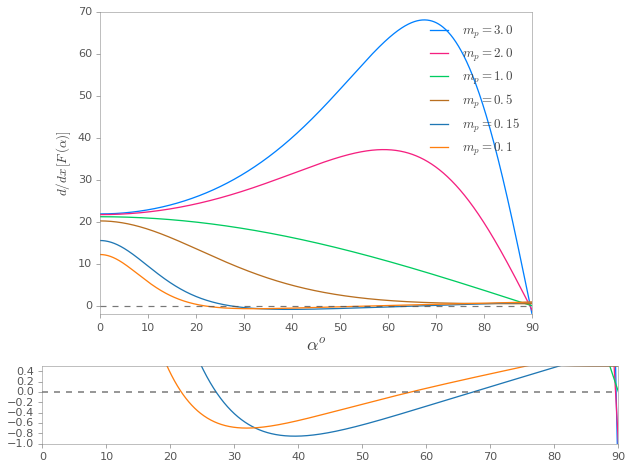

In [129]:
# plot of the first derivative
FIGURE_FOR_WORD = False

zo=-509.0
f = 24.0

if FIGURE_FOR_WORD:
    fig = plt.figure(figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig = plt.figure(figsize=(8, 6))
    tsf = 1.25

ax0 = fig.add_axes([0.1, 0.3, 0.75, 0.7])  # [*left*, *bottom*, *width*, *height*]
ax1 = fig.add_axes([0.0, 0.0, 1.0, 0.18,])

alpha = np.linspace(0., 89.9999, 1000)
#alpha = np.linspace(-89.9999, 89.9999, 1000)

#for i, mp in enumerate([5.0, 3.0, 2.0, 1.0, 0.5, 0.374, 0.37, 0.15, 0.1, 0.05]):
for i, mp in enumerate([3.0, 2.0, 1.0, 0.5, 0.15, 0.1]):
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, first_derivative_Falpha(zo, f, mp, alpha), label=legTxt)
    ax1.plot(alpha, first_derivative_Falpha(zo, f, mp, alpha))

# ticks
for ax in [ax0, ax1]:
    ax.yaxis.set_ticks_position('left')              
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)
ax0.xaxis.set_ticks_position('bottom') 
ax1.xaxis.set_ticks_position('bottom') 

# plot the case of mp=1 separately to verify
# ax0.plot(alpha, -(zo/f)*cosd(alpha), 'b', linestyle='dashed') # It does overlap

ax0.axhline(color='#555555', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axhline(color='#555555', alpha=0.8, lw=1.5, linestyle='dashed')

ax0.legend()   # TO DO:: Put the legend outside the ax0 to the left

ax0.set_ylim(-2, 70)
ax1.set_ylim(-1.0, 0.5)
ax0.set_ylabel(r'$d/dx \, [F\,(\alpha)]$')
ax0.set_xlabel(r'$\alpha^o$', fontsize=18)
plt.show()

In [7]:
def first_derivative_has_real_roots(zo, f, mp, alpha0=-89.0, alpha1=89.0):
    """returns True if the first derivative of the function F(alpha) have real roots 
    within the valid range of angles     
    
    If the function returns True, then F(\alpha) is NOT a monotonically increasing/decreasing 
    function and hence we will get two alpha for which the have the same beta
    """
    roots, disc = roots_first_derivative_Falpha(zo, f, mp)
    roots = np.array([arccosd(np.real(root)) for root in roots if np.isreal(root) and abs(root) <= 1.0])
    return np.any(np.logical_and((roots >= alpha0), (roots <= alpha1)))

In [23]:
for mp in [2.0, 1.0, 0.5, 0.3735, 0.37, 0.15]:
    print('---------------------------------------------------')
    print('mp =', mp)
    roots, disc = roots_first_derivative_Falpha(zo, f, mp)
    print('roots =', roots)
    print('discrimiant =', disc)
    print(first_derivative_has_real_roots(zo, f, mp))


---------------------------------------------------
mp = 2.0
roots = [ 1.76391344 -1.70104378  0.00785725]
discrimiant = 1.1611745388e+14
False
---------------------------------------------------
mp = 1.0
roots = [ 0.]
discrimiant = 0.0
False
---------------------------------------------------
mp = 0.5
roots = [ 0.27701187+0.38966389j  0.27701187-0.38966389j -0.41256990+0.j        ]
discrimiant = -62676747.0
False
---------------------------------------------------
mp = 0.3735
roots = [-0.68506956+0.j          0.42923127+0.00602201j  0.42923127-0.00602201j]
discrimiant = -45008.587169
False
---------------------------------------------------
mp = 0.37
roots = [-0.69045155  0.48256024  0.38247847]
discrimiant = 3144109.51663
True
---------------------------------------------------
mp = 0.15
roots = [-0.91464204  0.88996594  0.38616922]
discrimiant = 24809434.397
True


The only thing that seems to be useful is whether $F'(\alpha)$ has any real roots such that $-\pi/2 < \cos(x) < \pi/2$, where $x$ is a real root (if it exist). The discriminant is not very useful. 

For $m_p < 1.0$, if the discriminant is -ve then the roots are imaginary (which is good).

## Approximate formula for finding $\alpha$ given $\beta$

<font color='red'>**SKIP THIS AND GO TO ITERATIVE PROCEDURE FOR FINDING ALPHA**</font> 

The approximate formula for finding $\alpha$ given $\beta$ breaks down completely for smaller values of $m_p$. The iterative algorithm for finding $\alpha$ works well.

In [25]:
def alpha_thin(zo, f, beta):
    return -arcsind(f*tand(beta)/zo)

def alpha_approx(zo, f, mp, beta):
    a = 1
    alphaThin = alpha_thin(zo, f, beta)
    b = (mp*zo/cosd(alphaThin) + f*(1-mp))/(f*tand(beta))
    c = mp
    k = np.sqrt(b**2 - 4*a*c)
    #t1 = 0.5*(-b - k)
    #t2 = 0.5*(-b + k)
    #print(t1, t2)
    roots = arctand(0.5*(-b - k)), arctand(0.5*(-b + k))
    #print('roots = ', roots)
    return roots[0] if alphaThin > 0 else roots[1]

In [26]:
zo = -509.0
f = 24.0
mp = 2.0
alphaExact = 5.0
d = -20

betaExact = get_beta2(zo, f, mp, alphaExact)
alphaApprox = alpha_approx(zo, f, mp, betaExact)
print('beta = ', betaExact)
print('alpha (true) = ', alphaExact)
print('alpha (approximate) =', alphaApprox)
print('Effect of alpha approximate on zDash:')
print('zDash (true) = ', get_zoDash2(zo, f, mp, d, alphaExact))
print('zDash (approx) = ', get_zoDash2(zo, f, mp, d, alphaApprox))

beta =  62.2296825491
alpha (true) =  5.0
alpha (approximate) = 4.99895906397
Effect of alpha approximate on zDash:
zDash (true) =  29.2399513946
zDash (approx) =  29.2399175376


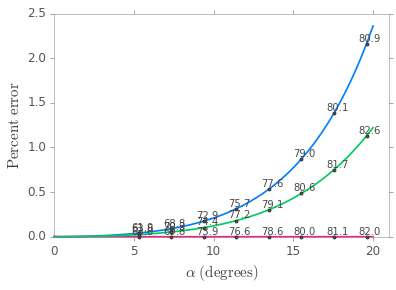

In [28]:
from matplotlib.ticker import FuncFormatter

zo = -509.0
f = 24.0
mpArr = [0.55, 1, 2.0]


fig, ax = plt.subplots(1, 1)
alphaExact = np.linspace(0.0001, 20)

for mp in mpArr:
    alphaApprox = []
    betaArr = []
    for alpha in alphaExact:
        beta = get_beta2(zo, f, mp, alpha)
        alphaApprox.append(alpha_approx(zo, f, mp, beta))
        betaArr.append(beta)
    alphaApprox = np.array(alphaApprox)
    err = np.abs(alphaExact - alphaApprox)
    relErr = 100.0*err/np.abs(alphaExact)#
    ax.plot(alphaExact, relErr, lw=1.7, clip_on=False)
    #ax.errorbar(alphaExact, relErr, xerr=0.0, yerr=err, clip_on=False)
    indices = np.argwhere(alphaExact > 5).flatten()[::5]
    ax.scatter(alphaExact[indices], relErr[indices], s=8, clip_on=False, 
               facecolor='#555555', edgecolor=None, zorder=10)
    for i in indices:
        ax.text(x=alphaExact[i]-0.5, y=relErr[i]+0.025, s='{:0.1f}'.format(betaArr[i]))
    
ax.set_ylabel(r'$\rm{Percent}\,\,\rm{error}$', fontsize=15)
ax.set_xlabel(r'$\alpha \,\,\rm(degrees)$', fontsize=15)
ax.set_xlim(alphaExact[0], alphaExact[-1] + 1)
ax.set_ylim(-0.001, 2.5)

#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Save the figure  
#saveFigure(fig, 'approximation_of_lens_tilt.png')

plt.show()

In [31]:
fl = 24.0
alphaOpt = -5.0
zo = -509.0
mp = 2.0
betaOpt = get_beta2(zo, fl, mp, alphaOpt)
print('beta_opt = ', betaOpt)
t = np.tan(np.deg2rad(betaOpt))

a = fl*mp*t
b = fl*t 
c = fl*(1-mp)/2.0
d = 0/2.0
e = mp*zo/2.0
f = 0

x = cosd(alphaOpt)
y = sind(alphaOpt)

print(a*x**2 + b*y**2 + 2*c*x*y + 2*d*x + 2*e*y + f)

print(t + sind(alphaOpt)*(mp*zo + fl*(1-mp)*cosd(alphaOpt))/(fl*(mp*cosd(alphaOpt)**2 + sind(alphaOpt)**2)))

beta_opt =  -62.2296825491
-5.68434188608e-14
-4.4408920985e-16


## Iterative algorithm for finding lens tilt angle $\alpha$

#### Condition for real image

The following cell shows that even if $F(\alpha)$ is monotonic, a combination of lens parameters and object plane distance could result in the case in which $\acute{z}_o$ is negative. We would like to avoid such cases.

abs(zo)*mp - f/cosd(alpha) =  1.38928453723
zeDash = 821.393942117
beta = -6.71908410729
roots = [-0.91827768+0.j          1.02408565+0.12702358j  1.02408565-0.12702358j]


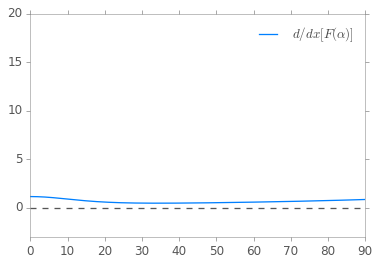

In [67]:
#zo=-539.359427021; f=89.8074019381; mp=0.155474178141; alpha=-6.10160377014;    # Image is virtual, zeDash is -ve
#zo=-539.359427021; f=83.38141419767325; mp=0.155474178141; alpha=-6.10160377014;  # Image at infinity
zo=-539.359427021; f=82; mp=0.155474178141; alpha=-6.10160377014;

print('abs(zo)*mp - f/cosd(alpha) = ', abs(zo)*mp - f/cosd(alpha))
# setting d=0, because I am just interested in zeDash

print('zeDash =', get_zoDash2(zo, f, mp, 0, alpha)) 

beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alpha)
print('beta =', beta)
roots, disc = roots_first_derivative_Falpha(zo, f, mp)
print('roots =', roots)

alpha = np.linspace(0., 89.9999, 1000)
plt.plot(alpha, first_derivative_Falpha(zo, f, mp, alpha), label=r'$d/dx [F(\alpha)]$')
#plt.plot(alpha, get_beta2(zo, f, mp, alpha), label='beta')
ax = plt.gca()
ax.axhline(color='#555555', linestyle='dashed')
#ax.set_ylim(-3, 60)
ax.set_ylim(-3, 20)
ax.legend()
plt.show()

#### An iterative procedure to find $\alpha$

A possible algorithm for finding $\alpha$ given $\beta$.

In [68]:
def alpha_thin(zo, f, beta):
    return -arcsind(f*tand(beta)/zo)

In [60]:
zo = -509.0
f = 24.0   # 100
mp = 0.55
alphaTrue = -15.0

# CONDITION #1
# first ensure that F(alpha) is monotonic for the given parameters 
if first_derivative_has_real_roots(zo, f, mp):
    assert False, "F(alpha) is not monotonic. Cannot find a unique alpha!"
else:
    roots, disc = roots_first_derivative_Falpha(zo, f, mp)
    print('roots', roots)
    
# CONDITION #2
assert (abs(zo)*mp - f/cosd(alphaTrue)) > 0.0, 'zeDash is negative; Image is not real'

# Generate a beta
beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alphaTrue)

# -------------------------------
# Main procedure starts here 

alphaInit = alpha_thin(zo=zo, f=f, beta=beta)

print('alpha (true) = ', alphaTrue)
print('beta =', beta)
print('Initial alpha = ', alphaInit)

errValStop = 1e-16
stepThreshold = 10
i = 0
t = tand(beta)
s = sind(alphaInit)
c = cosd(alphaInit)
prevErr = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
#prevErr = beta + arctand(s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))) # Initial merit function value
alpha_i = alphaInit
step = 0.5*prevErr

print("Initial error = ", prevErr)
print("np.arctan(prevErr) = ", np.arctan(prevErr))
print('Initial step = ', step)
print('np.arctan(step) =', np.arctan(step))
print()

while (abs(prevErr) > errValStop) and (i < stepThreshold):
    i += 1
    alpha_i += step 
    s = sind(alpha_i)
    c = cosd(alpha_i)
    err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
    #err = beta + arctand(s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)))
    deltaErr = err - prevErr   
    print('-------------')
    print('err({}) = {:2.4f}'.format(i, err))
    print('deltaErr({}) = {:2.4f}'.format(i, deltaErr))
    print('prevErr({}) = {:2.4f}'.format(i, prevErr))
    print('alpha({}) = {:2.4f}'.format(i, alpha_i))
    if np.sign(err)/np.sign(prevErr) < 0: # modify step direction and possibly size only if i > 0
        step = 0.5*deltaErr
        print('**Sign change: changing step to ', step)
    prevErr = err
    
print('Value of alpha after {} iterations = {:2.5f} (error = {:2.5e}, merit = {:2.5e})'
      .format(i, alpha_i, alphaTrue - alpha_i, err))

roots [ 0.19784279+0.53578773j  0.19784279-0.53578773j -0.26280472+0.j        ]
alpha (true) =  -15.0
beta = -78.7120373048
Initial alpha =  -13.6639828387
Initial error =  -0.398361241047
np.arctan(prevErr) =  -0.379092856052
Initial step =  -0.199180620523
np.arctan(step) = -0.196607570966

-------------
err(1) = -0.3382
deltaErr(1) = 0.0602
prevErr(1) = -0.3984
alpha(1) = -13.8632
-------------
err(2) = -0.2782
deltaErr(2) = 0.0599
prevErr(2) = -0.3382
alpha(2) = -14.0623
-------------
err(3) = -0.2186
deltaErr(3) = 0.0596
prevErr(3) = -0.2782
alpha(3) = -14.2615
-------------
err(4) = -0.1593
deltaErr(4) = 0.0594
prevErr(4) = -0.2186
alpha(4) = -14.4607
-------------
err(5) = -0.1002
deltaErr(5) = 0.0591
prevErr(5) = -0.1593
alpha(5) = -14.6599
-------------
err(6) = -0.0414
deltaErr(6) = 0.0588
prevErr(6) = -0.1002
alpha(6) = -14.8591
-------------
err(7) = 0.0171
deltaErr(7) = 0.0585
prevErr(7) = -0.0414
alpha(7) = -15.0582
**Sign change: changing step to  0.029242889561
--------

##### Testing the algorithm

In [58]:
def estimate_alpha(zo, f, mp, beta, maxSteps=250):
    """
    """
    errValStop = 1e-16
    stepThreshold = maxSteps
    i = 0
    t = tand(beta)
    alphaInit = alpha_thin(zo=zo, f=f, beta=beta)
    s = sind(alphaInit)
    c = cosd(alphaInit)
    prevErr = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
    alpha_i = alphaInit
    step = 0.5*prevErr

    while (abs(prevErr) > errValStop) and (i < stepThreshold):
        i += 1
        alpha_i += step 
        s = sind(alpha_i)
        c = cosd(alpha_i)
        err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
        deltaErr = err - prevErr   
        if np.sign(err)/np.sign(prevErr) < 0: 
            step = 0.5*deltaErr
        prevErr = err
    return alpha_i, i, err

In [59]:
for i in range(6000):
    mp = 0.1 + 4*np.random.random() 
    zo = -500 - 1000*np.random.random()
    f = 50 + 50*np.random.random()
    
    # Ensure that there is a unique alpha within +/-90° for the parameters
    if first_derivative_has_real_roots(zo, f, mp):
        continue  
    
    # generate a "True" alpha that we would like to determine
    alpha = (-1)**np.random.randint(1,3) * 30*np.random.random()
    
    # Ensure that the condition for real imaging is satisfied
    if (abs(zo)*mp - f/cosd(alpha)) <= 0.0:
        continue
    
    # generate the beta corresponding to the true alpha
    beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alpha)

    #     
    alphaEst, numSteps, _ = estimate_alpha(zo=zo, f=f, mp=mp, beta=beta)
    if abs(alpha - alphaEst) > 1e-5:
        print()
        print('mp = {}; zo = {}; f = {}; alpha = {}'.format(mp, zo, f, alpha))
        print('alpha (actual) = {:2.4f}; alpha (est) = {:2.4f}; steps = {}; error = {:2.2e}'
              .format(alpha, alphaEst, numSteps, alpha - alphaEst))


mp = 0.117711196058; zo = -709.208635801; f = 71.6645763898; alpha = 17.5298302134
alpha (actual) = 17.5298; alpha (est) = 17.5294; steps = 250; error = 3.99e-04

mp = 0.114250253391; zo = -910.609655556; f = 85.2319265725; alpha = -21.0455344962
alpha (actual) = -21.0455; alpha (est) = -21.0448; steps = 250; error = -7.44e-04

mp = 0.148212912441; zo = -534.062789862; f = 76.5808557901; alpha = -6.38395921045
alpha (actual) = -6.3840; alpha (est) = -6.3839; steps = 250; error = -6.13e-05

mp = 0.134108365951; zo = -546.154091812; f = 54.0355866661; alpha = 24.7647174221
alpha (actual) = 24.7647; alpha (est) = 24.7646; steps = 250; error = 1.24e-04

mp = 0.108045486049; zo = -900.456838707; f = 66.6639930395; alpha = -20.0088387617
alpha (actual) = -20.0088; alpha (est) = -20.0081; steps = 250; error = -7.29e-04

mp = 0.111070223191; zo = -780.780193828; f = 74.7052550688; alpha = -24.2508465321
alpha (actual) = -24.2508; alpha (est) = -24.3477; steps = 250; error = 9.69e-02

mp = 0.1